В связи с неподьемно увеличенным временем выполнения кода закомментировал код исследования данных. Сохранил выполнение полного кода в файле Credit_Score_HW.ipyntb

Ваша задача этом соревновании - предсказать факт невыполнения кредитных обязательств в датасете test.csv. Вам будут даны два датасета: train.csv (содержит признаки и факт невыполнения кредитных обязательств) и test.csv (только признаки).

Целевая переменная

Credit Default - факт невыполнения кредитных обязательств

Метрика качества

F1-score (sklearn.metrics.f1_score)

Требования к решению

Целевая метрика

F1 > 0.5
Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту) Это четвертый вид усреднения(не микро не макро) байнери.
Решение должно содержать

Тетрадка Jupyter Notebook с кодом Вашего решения
Укажите свой ник на kaggle
Рекомендации для файла с кодом (ipynb)

Файл должен содержать заголовки и комментарии (markdown)
Повторяющиеся операции лучше оформлять в виде функций
Не делать вывод большого количества строк таблиц (5-10 достаточно)
По возможности добавлять графики, описывающие данные (около 3-5)
Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
Весь проект должен быть в одном скрипте (файл ipynb).
Допускается применение библиотек Python и моделей машинного обучения, которые были в данном курсе.
Сроки сдачи

Cдать проект нужно в течение 7 дней после окончания последнего вебинара.

Описание датасета

Home Ownership - домовладение<br>
Annual Income - годовой доход<br>
Years in current job - количество лет на текущем месте работы<br>
Tax Liens - налоговые обременения<br>
Number of Open Accounts - количество открытых счетов<br>
Years of Credit History - количество лет кредитной истории<br>
Maximum Open Credit - наибольший открытый кредит<br>
Number of Credit Problems - количество проблем с кредитом<br>
Months since last delinquent - количество месяцев с последней просрочки платежа<br>
Bankruptcies - банкротства<br>
Purpose - цель кредита<br>
Term - срок кредита<br>
Current Loan Amount - текущая сумма кредита<br>
Current Credit Balance - текущий кредитный баланс<br>
Monthly Debt - ежемесячный долг<br>
Credit Score - баллы кредитного рейтинга<br>
Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)<br>

Построение модели классификации

Обзор обучающего датасета<br>
Обработка выбросов<br>
Обработка пропусков<br>
Анализ данных<br>
Отбор признаков<br>
Балансировка классов<br>
Подбор моделей, получение бейзлана<br>
Выбор наилучшей модели, настройка гиперпараметров<br>
Проверка качества, борьба с переобучением<br>
Интерпретация результатов<br>
Прогнозирование на тестовом датасете<br>
<br>

Выполнить для тестового датасета те же этапы обработки и построения признаков<br>
Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете<br>
Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)<br>
Соблюдать исходный порядок примеров из тестового датасета

In [2]:
!pip3 install catboost

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import pickle
import random
from pathlib import Path

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.model_selection import KFold, GridSearchCV
from sklearn import datasets
from sklearn.model_selection import cross_val_score
import catboost as catb
from catboost import CatBoostRegressor

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
from scipy.stats import shapiro
from scipy.stats import probplot # распределение на нормальность
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

In [5]:
import warnings
warnings.simplefilter('ignore')

In [6]:
from xgboost import XGBRegressor
from sklearn.datasets import make_regression

In [7]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [8]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [9]:
def evaluate_preds_nan(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [10]:
def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [11]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [12]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [13]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [14]:
def predict_proba_compare(model, X_test, X_train, y_test, y_train, cut_off):
    # функция изменения линии отсечки при расчете таргета
    pred_proba_test = model.predict_proba(X_test)
    y_test_proba=np.where(pred_proba_test[:, 1] > cut_off, 1, 0)
    pred_proba_train = model.predict_proba(X_train)
    y_train_proba=np.where(pred_proba_train[:, 1] > cut_off, 1, 0)
    print('TRAIN\n\n' + classification_report(y_train, y_train_proba))
    print('TEST\n\n' + classification_report(y_test, y_test_proba))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test, y_test_proba))
    
    return y_train_proba, y_test_proba

In [15]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'

In [16]:
#TRAIN_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/SKLearn_Project_Classific/train.csv'
#TEST_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/SKLearn_Project_Classific/test.csv'

**Загрузка данных**

In [17]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [18]:
df_train=df_train.rename(columns={'Home Ownership': 'Home_Ownership', 'Annual Income': 'Annual_Income', 'Years in current job': 'Years_in_current_job',
                         'Tax Liens': 'Tax_Liens', 'Number of Open Accounts': 'Number_of_Open_Accounts', 'Years of Credit History': 'Years_of_Credit_History', 
                         'Maximum Open Credit': 'Maximum_Open_Credit', 'Number of Credit Problems': 'Number_of_Credit_Problems', 'Months since last delinquent': 'Months_since_last_delinquent', 
                         'Current Loan Amount': 'Current_Loan_Amount', 'Current Credit Balance': 'Current_Credit_Balance', 'Monthly Debt': 'Monthly_Debt', 
                         'Credit Score': 'Credit_Score', 'Credit Default': 'Credit_Default'})

In [19]:
df_train.head()

,Home_Ownership,Annual_Income,Years_in_current_job,Tax_Liens,Number_of_Open_Accounts,Years_of_Credit_History,Maximum_Open_Credit,Number_of_Credit_Problems,Months_since_last_delinquent,Bankruptcies,Purpose,Term,Current_Loan_Amount,Current_Credit_Balance,Monthly_Debt,Credit_Score,Credit_Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [20]:
df_train.shape

(7500, 17)

In [21]:
df_train['Credit_Default'].value_counts()

0    5387
1    2113
Name: Credit_Default, dtype: int64

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home_Ownership                7500 non-null   object 
 1   Annual_Income                 5943 non-null   float64
 2   Years_in_current_job          7129 non-null   object 
 3   Tax_Liens                     7500 non-null   float64
 4   Number_of_Open_Accounts       7500 non-null   float64
 5   Years_of_Credit_History       7500 non-null   float64
 6   Maximum_Open_Credit           7500 non-null   float64
 7   Number_of_Credit_Problems     7500 non-null   float64
 8   Months_since_last_delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current_Loan_Amount           7500 non-null   float64
 13  Cur

In [23]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [24]:
df_test.shape

(2500, 16)

In [25]:
df_test=df_test.rename(columns={'Home Ownership': 'Home_Ownership', 'Annual Income': 'Annual_Income', 'Years in current job': 'Years_in_current_job',
                         'Tax Liens': 'Tax_Liens', 'Number of Open Accounts': 'Number_of_Open_Accounts', 'Years of Credit History': 'Years_of_Credit_History', 
                         'Maximum Open Credit': 'Maximum_Open_Credit', 'Number of Credit Problems': 'Number_of_Credit_Problems', 'Months since last delinquent': 'Months_since_last_delinquent', 
                         'Current Loan Amount': 'Current_Loan_Amount', 'Current Credit Balance': 'Current_Credit_Balance', 'Monthly Debt': 'Monthly_Debt', 
                         'Credit Score': 'Credit_Score'})

In [26]:
df_test.head()

,Home_Ownership,Annual_Income,Years_in_current_job,Tax_Liens,Number_of_Open_Accounts,Years_of_Credit_History,Maximum_Open_Credit,Number_of_Credit_Problems,Months_since_last_delinquent,Bankruptcies,Purpose,Term,Current_Loan_Amount,Current_Credit_Balance,Monthly_Debt,Credit_Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0


## 1. **РАЗБОР ПЕРЕМЕННЫХ НА КАТЕГОРИИ**  <a class='anchor' id='eda'>

In [27]:
TARGET_NAME = 'Credit_Default'
BASE_FEATURE_NAMES = df_train.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES).tolist()

**Целевая переменная**

In [28]:
df_train['Credit_Default'].value_counts()

0    5387
1    2113
Name: Credit_Default, dtype: int64

**Количественные переменные**

In [29]:
df_train.describe()

,Annual_Income,Tax_Liens,Number_of_Open_Accounts,Years_of_Credit_History,Maximum_Open_Credit,Number_of_Credit_Problems,Months_since_last_delinquent,Bankruptcies,Current_Loan_Amount,Current_Credit_Balance,Monthly_Debt,Credit_Score,Credit_Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [30]:
df_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

['Annual_Income',
 'Tax_Liens',
 'Number_of_Open_Accounts',
 'Years_of_Credit_History',
 'Maximum_Open_Credit',
 'Number_of_Credit_Problems',
 'Months_since_last_delinquent',
 'Bankruptcies',
 'Current_Loan_Amount',
 'Current_Credit_Balance',
 'Monthly_Debt',
 'Credit_Score',
 'Credit_Default']

**Номинативные переменные**

In [31]:
df_train.select_dtypes(include='object').columns.tolist()

['Home_Ownership', 'Years_in_current_job', 'Purpose', 'Term']

In [32]:
df_train.Home_Ownership.value_counts()

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home_Ownership, dtype: int64

In [33]:
df_train.Years_in_current_job.value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years_in_current_job, dtype: int64

In [34]:
df_train.Purpose.value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

In [35]:
df_train.Term.value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

In [36]:
NUM_FEATURE_NAMES = ['Annual_Income', 'Tax_Liens', 'Number_of_Open_Accounts', 'Years_of_Credit_History',
                    'Maximum_Open_Credit', 'Number_of_Credit_Problems', 'Months_since_last_delinquent',
                    'Bankruptcies', 'Current_Loan_Amount', 'Current_Credit_Balance', 'Monthly_Debt', 'Credit_Score'
                    ]

CAT_FEATURE_NAMES = ['Home_Ownership', 'Years_in_current_job', 'Purpose', 'Term']

SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES + NEW_FEATURE_NAMES

## 2. **Похожесть теста и трейна**  <a class='anchor' id='eda'>

Визуализирую признаки на трейне и тесте.

Annual_Income
MannwhitneyuResult(statistic=9362155.5, pvalue=0.45908193952511717)


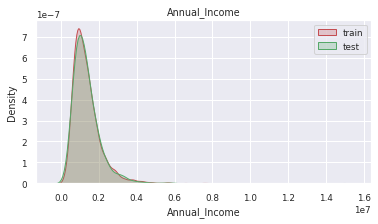

Tax_Liens
MannwhitneyuResult(statistic=9336937.5, pvalue=0.09836860283803656)


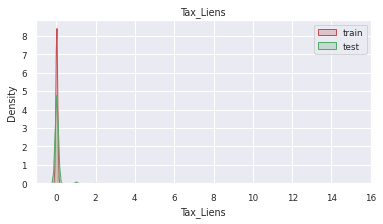

Number_of_Open_Accounts
MannwhitneyuResult(statistic=9279311.5, pvalue=0.22142637178864455)


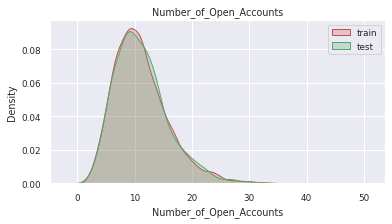

Years_of_Credit_History
MannwhitneyuResult(statistic=9339658.0, pvalue=0.3886945952485082)


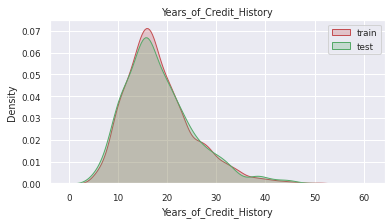

Maximum_Open_Credit
MannwhitneyuResult(statistic=9337869.0, pvalue=0.3832220993414893)


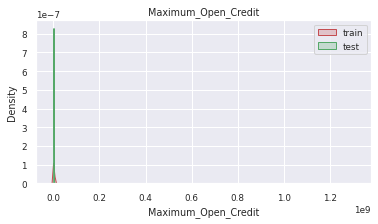

Number_of_Credit_Problems
MannwhitneyuResult(statistic=9295513.5, pvalue=0.14195772552376257)


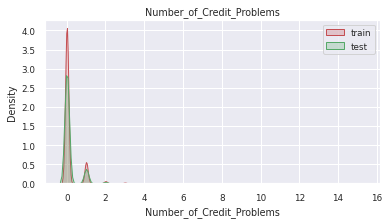

Months_since_last_delinquent
MannwhitneyuResult(statistic=6974400.5, pvalue=1.712573746209761e-82)


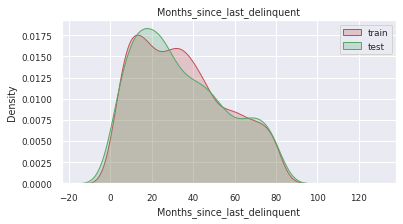

Bankruptcies
MannwhitneyuResult(statistic=9254231.0, pvalue=0.036681545859698156)


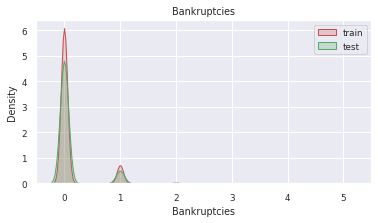

Current_Loan_Amount
MannwhitneyuResult(statistic=9230199.5, pvalue=0.12317435968682072)


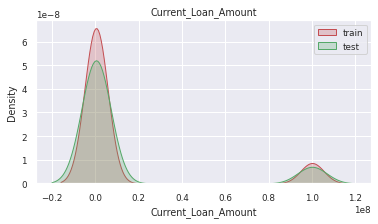

Current_Credit_Balance
MannwhitneyuResult(statistic=9334050.0, pvalue=0.3716147491364306)


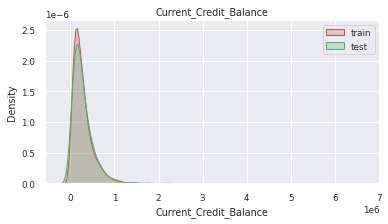

Monthly_Debt
MannwhitneyuResult(statistic=9288187.0, pvalue=0.24369523330673137)


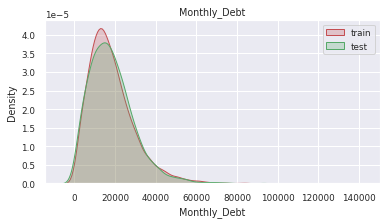

Credit_Score
MannwhitneyuResult(statistic=9359581.5, pvalue=0.45091647518794764)


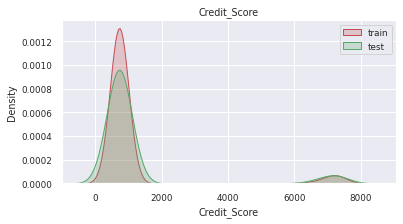

In [37]:
figsize = (6, 3)
for col in NUM_FEATURE_NAMES:
    plt.figure(figsize=figsize)
    sns.set(font_scale=0.8)
    sns.kdeplot(df_train[col], shade=True, label='train', color='r')
    sns.kdeplot(df_test[col], shade=True, label='test', color='g')
    print(col)
    print(mannwhitneyu(df_train[col], df_test[col]))
    plt.legend()
    plt.title(col)
    plt.show()

Методом Шапиро-Уилка проверяю на нормальность.Оценю эквивалентность мат. ожадиний трейна и теста, с помощью критерия Манна-Уитни и построю доверительные интервалы для средних значений, каждой из двух групп.

In [38]:
# Функция создания датафрейма для доверительных интервалов
def for_compare(X):
    For_compare = pd.DataFrame(df_train[X])
    For_compare['Is_train'] = 1
    For_compare2 = pd.DataFrame(df_test[X])
    For_compare2['Is_train'] = 0
    For_compare = pd.concat([For_compare, For_compare2], axis=0)

    return For_compare


In [39]:
df_train_med=df_train.fillna(value=df_train.median())

In [40]:
df_test_med=df_test.fillna(value=df_train.median())

**Annual_Income**

In [41]:
#mannwhitneyu(df_train['Annual_Income'], df_test['Annual_Income'])

In [42]:
#Annual_Income_for_compare = for_compare('Annual_Income')

In [43]:
#plt.figure(figsize=(8, 5))

#sns.pointplot(x='Is_train', y='Annual_Income', data=Annual_Income_for_compare, capsize=.1)

#plt.title('Confidence intervals (95 %) for Annual_Income')
#plt.show()

**Months_since_last_delinquent**

In [44]:
#mannwhitneyu(df_train['Months_since_last_delinquent'], df_test['Months_since_last_delinquent'])

In [45]:
#Months_since_last_delinquent_for_compare = for_compare('Months_since_last_delinquent')

In [46]:
#plt.figure(figsize=(8, 5))

#sns.pointplot(x='Is_train', y='Months_since_last_delinquent', data=Months_since_last_delinquent_for_compare, capsize=.1)

#plt.title('Confidence intervals (95 %) for Months_since_last_delinquent')
#plt.show()

**Credit_Score**

In [47]:
#mannwhitneyu(df_train['Credit_Score'], df_test['Credit_Score'])

In [48]:
#Credit_Score_for_compare = for_compare('Credit_Score')

In [49]:
#plt.figure(figsize=(8, 5))

#sns.pointplot(x='Is_train', y='Credit_Score', data=Credit_Score_for_compare, capsize=.1)

#plt.title('Confidence intervals (95 %) for Credit_Score')
#plt.show()

На kdeplot графики совпадают. Нужно оставить признак. 

**Tax_Liens**

In [50]:
#shapiro(df_train['Tax_Liens'])

In [51]:
#shapiro(df_test['Tax_Liens'])

In [52]:
#mannwhitneyu(df_train['Tax_Liens'], df_test['Tax_Liens'])

In [53]:
#Tax_Liens_for_compare = pd.DataFrame(df_train['Tax_Liens'])

In [54]:
#Tax_Liens_for_compare['Is_train'] = 1

In [55]:
#Tax_Liens_for_compare2 = pd.DataFrame(df_test['Tax_Liens'])

In [56]:
#Tax_Liens_for_compare2['Is_train'] = 0

In [57]:
#Tax_Liens_for_compare = pd.concat([Tax_Liens_for_compare, Tax_Liens_for_compare2], axis=0)

In [58]:
#plt.figure(figsize=(8, 5))

#sns.pointplot(x='Is_train', y='Tax_Liens', data=Tax_Liens_for_compare, capsize=.1)

#plt.title('Confidence intervals (95 %) for Tax_Liens')
#plt.show()

**Number_of_Open_Accounts**

In [59]:
#shapiro(df_train['Number_of_Open_Accounts'])

In [60]:
#shapiro(df_test['Number_of_Open_Accounts'])

In [61]:
#mannwhitneyu(df_train['Number_of_Open_Accounts'], df_test['Number_of_Open_Accounts'])

In [62]:
#Number_of_Open_Accounts_for_compare = for_compare('Number_of_Open_Accounts')

In [63]:
#plt.figure(figsize=(8, 5))

#sns.pointplot(x='Is_train', y='Number_of_Open_Accounts', data=Number_of_Open_Accounts_for_compare, capsize=.1)

#plt.title('Confidence intervals (95 %) for Number_of_Open_Accounts')
#plt.show()

**Years_of_Credit_History**

In [64]:
#shapiro(df_train['Years_of_Credit_History'])

In [65]:
#shapiro(df_test['Years_of_Credit_History'])

In [66]:
#mannwhitneyu(df_train['Years_of_Credit_History'], df_test['Years_of_Credit_History'])

In [67]:
#Years_of_Credit_History_for_compare = for_compare('Years_of_Credit_History')

In [68]:
#plt.figure(figsize=(8, 5))

#sns.pointplot(x='Is_train', y='Years_of_Credit_History', data=Years_of_Credit_History_for_compare, capsize=.1)

#plt.title('Confidence intervals (95 %) for Years_of_Credit_History')
#plt.show()

**Maximum_Open_Credit**

In [69]:
#shapiro(df_train['Maximum_Open_Credit'])

In [70]:
#shapiro(df_test['Maximum_Open_Credit'])

In [71]:
#mannwhitneyu(df_train['Maximum_Open_Credit'], df_test['Maximum_Open_Credit'])

In [72]:
#Maximum_Open_Credit_for_compare = for_compare('Maximum_Open_Credit')

In [73]:
#plt.figure(figsize=(8, 5))

#sns.pointplot(x='Is_train', y='Maximum_Open_Credit', data=Maximum_Open_Credit_for_compare, capsize=.1)

#plt.title('Confidence intervals (95 %) for Maximum_Open_Credit')
#plt.show()

На kdeplot большая разница по плотности, но в целом видно совпадение. Оставить.

**Number_of_Credit_Problems**

In [74]:
#shapiro(df_train['Number_of_Credit_Problems'])

In [75]:
#shapiro(df_test['Number_of_Credit_Problems'])

In [76]:
#mannwhitneyu(df_train['Number_of_Credit_Problems'], df_test['Number_of_Credit_Problems'])

In [77]:
#Number_of_Credit_Problems_for_compare = for_compare('Number_of_Credit_Problems')

In [78]:
#plt.figure(figsize=(8, 5))

#sns.pointplot(x='Is_train', y='Number_of_Credit_Problems', data=Number_of_Credit_Problems_for_compare, capsize=.1)

#plt.title('Confidence intervals (95 %) for Number_of_Credit_Problems')
#plt.show()

**Bankruptcies**

Здесь небольшое количество Nanов

In [79]:
#shapiro(df_train_med['Bankruptcies'])

In [80]:
#shapiro(df_test_med['Bankruptcies'])

In [81]:
#mannwhitneyu(df_train_med['Bankruptcies'], df_test_med['Bankruptcies'])

In [82]:
#Bankruptcies_for_compare = for_compare('Bankruptcies')

In [83]:
#plt.figure(figsize=(8, 5))

#sns.pointplot(x='Is_train', y='Bankruptcies', data=Bankruptcies_for_compare, capsize=.1)

#plt.title('Confidence intervals (95 %) for Bankruptcies')
#plt.show()

На kdeplot графики визуально совпадают. Оставить.

**Current_Loan_Amount**

In [84]:
#shapiro(df_train['Current_Loan_Amount'])

In [85]:
#shapiro(df_test['Current_Loan_Amount'])

In [86]:
#mannwhitneyu(df_train['Current_Loan_Amount'], df_test['Current_Loan_Amount'])

In [87]:
#Current_Loan_Amount_for_compare = for_compare('Current_Loan_Amount')

In [88]:
#plt.figure(figsize=(8, 5))

#sns.pointplot(x='Is_train', y='Current_Loan_Amount', data=Current_Loan_Amount_for_compare, capsize=.1)

#plt.title('Confidence intervals (95 %) for Current_Loan_Amount')
#plt.show()

**Current_Credit_Balance**

In [89]:
#shapiro(df_train['Current_Credit_Balance'])

In [90]:
#shapiro(df_test['Current_Credit_Balance'])

In [91]:
#mannwhitneyu(df_train['Current_Credit_Balance'], df_test['Current_Credit_Balance'])

In [92]:
#Current_Credit_Balance_for_compare = for_compare('Current_Credit_Balance')

In [93]:
#plt.figure(figsize=(8, 5))

#sns.pointplot(x='Is_train', y='Current_Credit_Balance', data=Current_Credit_Balance_for_compare, capsize=.1)

#plt.title('Confidence intervals (95 %) for Current_Credit_Balance')
#plt.show()

**Monthly_Debt**

In [94]:
#shapiro(df_train['Monthly_Debt'])

In [95]:
#shapiro(df_test['Monthly_Debt'])

In [96]:
#mannwhitneyu(df_train['Monthly_Debt'], df_test['Monthly_Debt'])

In [97]:
#Monthly_Debt_for_compare = for_compare('Monthly_Debt')

In [98]:
#plt.figure(figsize=(8, 5))

#sns.pointplot(x='Is_train', y='Monthly_Debt', data=Monthly_Debt_for_compare, capsize=.1)

#plt.title('Confidence intervals (95 %) for Monthly_Debt')
#plt.show()

**Категориальные признаки**

**Home_Ownership_for_compare**

In [99]:
#Home_Ownership_for_compare = for_compare('Home_Ownership')

In [100]:
#Home_Ownership_for_compare['id']=Home_Ownership_for_compare.index

In [101]:
#table = Home_Ownership_for_compare.pivot_table(values='id', index='Is_train', columns='Home_Ownership', aggfunc='count')
#table

In [102]:
#chi2, p, _, _ = chi2_contingency(table)
#p

**Years_in_current_job**

In [103]:
#Years_in_current_job_for_compare = for_compare('Years_in_current_job')
#Years_in_current_job_for_compare['id']=Years_in_current_job_for_compare.index
#table = Years_in_current_job_for_compare.pivot_table(values='id', index='Is_train', columns='Years_in_current_job', aggfunc='count')
#table

In [104]:
#chi2, p, _, _ = chi2_contingency(table)
#p

**Purpose**

In [105]:
#Purpose_for_compare = for_compare('Purpose')
#Purpose_for_compare['id']=Purpose_for_compare.index
#table = Purpose_for_compare.pivot_table(values='id', index='Is_train', columns='Purpose', aggfunc='count')
#table

In [106]:
#table.drop('renewable energy', axis=1, inplace=True)

In [107]:
#chi2, p, _, _ = chi2_contingency(table)
#p

**Term**

In [108]:
#Term_for_compare = for_compare('Term')
#Term_for_compare['id']=Term_for_compare.index
#table = Term_for_compare.pivot_table(values='id', index='Is_train', columns='Term', aggfunc='count')
#table

In [109]:
#chi2, p, _, _ = chi2_contingency(table)
#p

## 3. **Корреляция с базовыми признаками**  <a class='anchor' id='eda'>

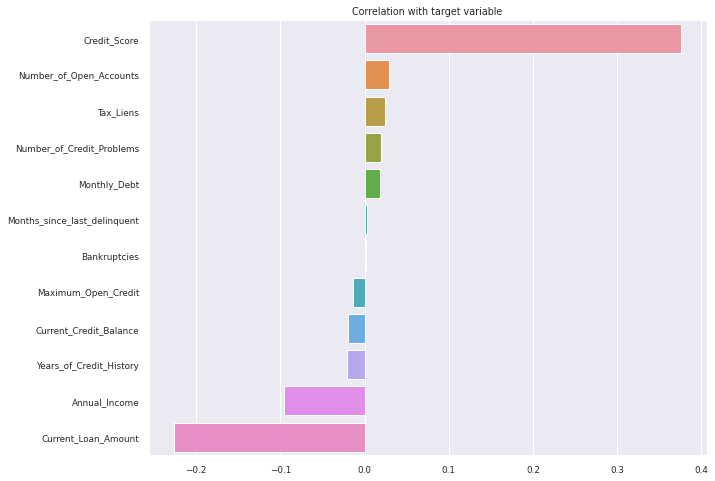

In [110]:
corr_with_target = df_train_med[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Исследую Credit_Score, Annual_Income и Current_Loan_Amount

**Credit_Score**

In [111]:
#df_train.Credit_Score.isna().sum()

In [112]:
#Credit_Score_with_target = df_train[['Credit_Score', TARGET_NAME]]
#Credit_Score = Credit_Score_with_target['Credit_Score']
#Credit_Score_target_0 = Credit_Score[Credit_Score_with_target[TARGET_NAME] == 0] 
#Credit_Score_target_1 = Credit_Score[Credit_Score_with_target[TARGET_NAME] == 1]

#plt.figure(figsize=(10, 5))

#sns.kdeplot(Credit_Score_target_0, shade=True, label='Погашен вовремя', color='g')
#sns.kdeplot(Credit_Score_target_1, shade=True, label='Просрочка', color='r')

#plt.xlabel('Credit_Score')
#plt.title('Credit_Score grouped by target variable')
#plt.show()

In [113]:
#plt.figure(figsize=(10, 5))

#sns.kdeplot(Credit_Score_target_0[df_train.Credit_Score < 2000], shade=True, label='Погашен вовремя', color='g')
#sns.kdeplot(Credit_Score_target_1[df_train.Credit_Score < 2000], shade=True, label='Просрочка', color='r')

#plt.xlabel('Credit_Score')
#plt.title('Credit_Score grouped by target variable')
#plt.show()

In [114]:
#plt.figure(figsize=(10, 5))

#sns.kdeplot(Credit_Score_target_0[df_train.Credit_Score > 6000], shade=True, label='Погашен вовремя', color='g')
#sns.kdeplot(Credit_Score_target_1[df_train.Credit_Score > 6000], shade=True, label='Просрочка', color='r')

#plt.xlabel('Credit_Score')
#plt.title('Credit_Score grouped by target variable')
#plt.show()

На 1 видно выбросы справа, с ними что-то надо делать. Признак качественный, но много Нанов.

**Annual_Income**

In [115]:
#df_train.Annual_Income.isna().sum()

In [116]:
#Annual_Income_with_target = df_train[['Annual_Income', TARGET_NAME]]
#Annual_Income = Annual_Income_with_target['Annual_Income']
#Annual_Income_target_0 = Annual_Income[Annual_Income_with_target[TARGET_NAME] == 0] 
#Annual_Income_target_1 = Annual_Income[Annual_Income_with_target[TARGET_NAME] == 1]

#plt.figure(figsize=(10, 5))

#sns.kdeplot(Annual_Income_target_0, shade=True, label='Погашен вовремя', color='g')
#sns.kdeplot(Annual_Income_target_1, shade=True, label='Просрочка', color='r')

#plt.xlabel('Annual_Income')
#plt.title('Annual_Income grouped by target variable')
#plt.show()

In [117]:
#shapiro(df_train_med['Annual_Income'])

In [118]:
#plt.figure(figsize=(20, 8))

#ax1 = plt.subplot(121)
#ax1.set_xlabel('Annual_Income')
#ax1.set_ylabel('Count')
#ax1.set_title('Annual_Income distribution')
#Annual_Income.hist()

#plt.subplot(122)
#probplot(Annual_Income, dist='norm', plot=plt)

#plt.show()

Воспользуюсь критерием Манна_Уитни для проверки гипотезы о равности матожиданий.

In [119]:
#mannwhitneyu(Annual_Income_target_0, Annual_Income_target_1)

Построю доверительные интервалы

In [120]:
#plt.figure(figsize=(8, 5))

#sns.pointplot(x=TARGET_NAME, y='Annual_Income', data=Annual_Income_with_target, capsize=.1)

#plt.title('Confidence intervals (95 %) for Annual_Income')
#plt.show()

Гипотеза о равности средних отвергается. Признак полезный. На "нулевом графике есть выбросы справа но для погашенной зкадолженности это логично.

**Current_Loan_Amount**

In [121]:
#df_train.Current_Loan_Amount.isna().sum()

In [122]:
#Current_Loan_Amount_with_target = df_train[['Current_Loan_Amount', TARGET_NAME]]
#Current_Loan_Amount = Current_Loan_Amount_with_target['Current_Loan_Amount']
#Current_Loan_Amount_target_0 = Current_Loan_Amount[Current_Loan_Amount_with_target[TARGET_NAME] == 0] 
#Current_Loan_Amount_target_1 = Current_Loan_Amount[Current_Loan_Amount_with_target[TARGET_NAME] == 1]

#plt.figure(figsize=(10, 5))

#sns.kdeplot(Current_Loan_Amount_target_0, shade=True, label='Погашен вовремя', color='g')
#sns.kdeplot(Current_Loan_Amount_target_1, shade=True, label='Просрочка', color='r')

#plt.xlabel('Current_Loan_Amount')
#plt.title('Current_Loan_Amount grouped by target variable')
#plt.show()

In [123]:
#plt.figure(figsize=(10, 5))

#sns.kdeplot(Current_Loan_Amount_target_0[Current_Loan_Amount_with_target.Current_Loan_Amount < 20000000], shade=True, label='Погашен вовремя', color='g')
#sns.kdeplot(Current_Loan_Amount_target_1[Current_Loan_Amount_with_target.Current_Loan_Amount < 20000000], shade=True, label='Просрочка', color='r')

#plt.xlabel('Current_Loan_Amount')
#plt.title('Current_Loan_Amount grouped by target variable')
#plt.show()

In [124]:
#shapiro(df_train['Current_Loan_Amount'])

In [125]:
#plt.figure(figsize=(20, 8))

#ax1 = plt.subplot(121)
#ax1.set_xlabel('Current_Loan_Amount')
#ax1.set_ylabel('Count')
#ax1.set_title('Current_Loan_Amount distribution')
#Current_Loan_Amount.hist()

#plt.subplot(122)
#probplot(Current_Loan_Amount, dist='norm', plot=plt)

#plt.show()

In [126]:
#mannwhitneyu(Current_Loan_Amount_target_0, Current_Loan_Amount_target_1)

In [127]:
#plt.figure(figsize=(8, 5))

#sns.pointplot(x=TARGET_NAME, y='Current_Loan_Amount', data=Current_Loan_Amount_with_target, capsize=.1)

#plt.title('Confidence intervals (95 %) for Current_Loan_Amount')
#plt.show()

Признак полезный. 

## 4. **Работа с категориальными признаками**  <a class='anchor' id='eda'>

Строю доверительные интервалы по полной наиболее коррелирующей c целевой фиче.

In [128]:
#num_feature = 'Current_Loan_Amount'
#for col in CAT_FEATURE_NAMES:
 #   plt.figure(figsize=figsize)
  #  sns.pointplot(x=col, y=num_feature, data=df_train, capsize=.1, label='train', color='r')
   # sns.pointplot(x=col, y=num_feature, data=df_test, capsize=.1, label='test', color='g')
    #plt.title(col) 
    #plt.show()

In [129]:
#df_train_cat = df_train[CAT_FEATURE_NAMES + [TARGET_NAME]]
#df_train['Id'] = df_train.index
#df_train.head()

In [130]:
keys2=[]

In [131]:
def corr_for_terget(feature, keys=keys2, df=df_train):
    # Построение матрицы корреляции
    keys2.sort()
    values2 = [1] * len(keys2)
    values3=[]
    for i in range(len(keys2)):
        values3.append(values2)
    dictionary = dict(zip(keys2, values3))
    Matrix=pd.DataFrame(dictionary)
    b=pd.Series(keys2)
    Matrix.insert(0, 'Item', b)   
    for i in range(len(keys2)):
        for j in range(len(keys2)):
            feature_and_target_s = df.loc[df[feature].isin([keys2[i], keys2[j]]),['Id', feature, TARGET_NAME]]
            table = feature_and_target_s.pivot_table(values='Id', index=feature, columns=TARGET_NAME, aggfunc='count')
            chi2, p, _, _ = chi2_contingency(table)
            Matrix.loc[i, keys2[j]] = p 
    Matrix.set_index('Item', inplace=True)

    return Matrix 

In [132]:
#df_train.value_counts()

**Оценка признака "Home_Ownership" в разрезе целевой переменной**

In [133]:
#plt.figure(figsize=(10, 8))

#sns.countplot(x="Home_Ownership", hue=TARGET_NAME, data=df_train)
#plt.title('Home_Ownership grouped by target variable')
#plt.legend(title='Target', loc='upper right')

#plt.show()

In [134]:
#df_train.Home_Ownership.unique().tolist()

In [135]:
#keys2=['Own Home', 'Home Mortgage', 'Rent', 'Have Mortgage']

In [136]:
#Matrix=corr_for_terget("Home_Ownership", keys=keys2, df=df_train)

In [137]:
#plt.figure(figsize = (15,10))

#sns.set(font_scale=1.4)
#Matrix = np.round(Matrix, 2) 
#Matrix[np.abs(Matrix) < 0.1] 
#sns.heatmap(Matrix, annot=True, linewidths=.5, cmap='coolwarm')

#plt.title('chi2 correlation matrix for Home_Ownership')
#plt.show()

Объединяю значения

In [138]:
def change_Home_Ownership(df):
    df.loc[df['Home_Ownership'].isin(['Home Mortgage', 'Have Mortgage']),'Home_Ownership'] = 'Mortgage'
    df.loc[df['Home_Ownership'].isin(['Own Home', 'Rent']), 'Home_Ownership'] = 'Own_Rent'
    return df

In [139]:
#df_train=change_Home_Ownership(df_train)
#df_test=change_Home_Ownership(df_test)

In [140]:
#plt.figure(figsize=(10, 8))

#sns.countplot(x="Home_Ownership", hue=TARGET_NAME, data=df_train)
#plt.title('Home_Ownership grouped by target variable')
#plt.legend(title='Target', loc='upper right')

#plt.show()

In [141]:
#plt.figure(figsize=figsize)
#sns.pointplot(x='Home_Ownership', y=num_feature, data=df_train, capsize=.1, label='train', color='r')
#sns.pointplot(x='Home_Ownership', y=num_feature, data=df_test, capsize=.1, label='test', color='g')
#plt.title(col) 
#plt.show()

На Катбусте целевая метрика при объединении упала с 0,57/0,54 до 0,62/0,54

**Оценка признака "Years_in_current_job" в разрезе целевой переменной**

In [142]:
#plt.figure(figsize=(10, 8))

#sns.countplot(x="Years_in_current_job", hue=TARGET_NAME, data=df_train)
#plt.title('Years_in_current_job grouped by target variable')
#plt.legend(title='Target', loc='upper right')

#plt.show()

In [143]:
#df_train['Years_in_current_job'].unique().tolist()

In [144]:
#keys2 = ['10+ years', '8 years', '6 years', '7 years', '5 years', '1 year', '< 1 year', '4 years',
 #        '3 years', '2 years', '9 years']
#keys2.sort()

In [145]:
#values2 = [1] * len(keys2)
#values3=[]

In [146]:
#for i in range(len(keys2)):
 #   values3.append(values2)

In [147]:
#dictionary = dict(zip(keys2, values3))
#Matrix=pd.DataFrame(dictionary)

In [148]:
#b=pd.Series(keys2)
#Matrix.insert(0, 'Item', b)

In [149]:
#for i in range(len(keys2)):
 #   for j in range(len(keys2)):
  #      Years_in_current_job_and_target_s = df_train.loc[df_train['Years_in_current_job'].isin([keys2[i], keys2[j]]),['Id', 'Years_in_current_job', TARGET_NAME]]
   #     table = Years_in_current_job_and_target_s.pivot_table(values='Id', index='Years_in_current_job', columns=TARGET_NAME, aggfunc='count')
    #    chi2, p, _, _ = chi2_contingency(table)
     #   Matrix.loc[i, keys2[j]] = p

In [150]:
#Matrix.set_index('Item', inplace=True)

In [151]:
#plt.figure(figsize = (15,10))

#sns.set(font_scale=1.4)
#Matrix = np.round(Matrix, 2) 
#Matrix[np.abs(Matrix) < 0.1] = 0 
#sns.heatmap(Matrix, annot=True, linewidths=.5, cmap='coolwarm')

#plt.title('chi2 correlation matrix')
#plt.show()

Все значения в признаке "Years_in_current_job" в разрезе целевой переменной коррелируют. Признак бесполезен.

In [152]:
#df_train.drop("Years_in_current_job", axis=1, inplace=True)

In [153]:
#df_test.drop("Years_in_current_job", axis=1, inplace=True)

**Оценка признака "Purpose" в разрезе целевой переменной**

In [154]:
#plt.figure(figsize=(10, 8))

#sns.countplot(x="Purpose", hue=TARGET_NAME, data=df_train)
#plt.title('Purpose grouped by target variable')
#plt.legend(title='Target', loc='upper right')

#plt.show()

In [155]:
#df_train.Purpose.isna().sum()

In [156]:
#df_train.Purpose.unique().tolist()

In [157]:
#keys2 = ['debt consolidation', 'other', 'home improvements', 'take a trip', 'buy a car', 'small business', 'business loan', 'wedding', 'educational expenses',
 #         'buy house', 'medical bills', 'moving', 'major purchase', 'vacation', 'renewable energy']

In [158]:
#Matrix=corr_for_terget("Purpose", keys=keys2, df=df_train)

In [159]:
#plt.figure(figsize = (15,10))

#sns.set(font_scale=1.4)
#Matrix = np.round(Matrix, 2) 
#Matrix[np.abs(Matrix) < 0.1] = 0  
#sns.heatmap(Matrix, annot=True, linewidths=.5, cmap='coolwarm')

#plt.title('chi2 correlation matrix for "Purpose"')
#plt.show()

Объединю признаки. Это общая функция для всех 3 преобразований.

In [160]:
def change_Purpose(df):
    df.loc[df['Purpose'].isin(['take a trip', 'buy a car']),'Purpose'] = 'take_buy'
    df.loc[df['Purpose'].isin(['medical bills', 'wedding']), 'Purpose'] = 'medical_wedding'
    df.loc[df['Purpose'].isin(['other', 'vacation']),'Purpose'] = 'other_vacation'
    df.loc[df['Purpose'].isin(['educational expenses', 'moving']), 'Purpose'] = 'educational_moving'
    df.loc[df['Purpose'].isin(['buy house', 'major purchase']),'Purpose'] = 'buy_major'
    df.loc[df['Purpose'].isin(['small business', 'business loan']),'Purpose'] = 'business_small'
    df.loc[df['Purpose'].isin(['take_buy', 'buy_major']),'Purpose'] = 'major_buy'
    df.loc[df['Purpose'].isin(['debt consolidation', 'home improvements']), 'Purpose'] = 'debt_home'
    df.loc[df['Purpose'].isin(['educational_moving', 'medical_wedding']),'Purpose'] = 'educational_medical'
    df.loc[df['Purpose'].isin(['debt_home', 'educational_medical']),'Purpose'] = 'educational_debt'
    df.loc[df['Purpose'].isin(['other_vacation', 'major_buy']), 'Purpose'] = 'other_major'
    
    return df

In [161]:
#def change_Purpose2(df):
 #   df.loc[df['Purpose'].isin(['take_buy', 'buy_major']),'Purpose'] = 'major_buy'
  #  df.loc[df['Purpose'].isin(['debt consolidation', 'home improvements']), 'Purpose'] = 'debt_home'
   # df.loc[df['Purpose'].isin(['educational_moving', 'medical_wedding']),'Purpose'] = 'educational_medical'

    #return df

In [162]:
#def change_Purpose3(df):
 #   df.loc[df['Purpose'].isin(['debt_home', 'educational_medical']),'Purpose'] = 'educational_debt'
  #  df.loc[df['Purpose'].isin(['other_vacation', 'major_buy']), 'Purpose'] = 'other_major'

   # return df

In [163]:
df_train=change_Purpose(df_train)
df_test=change_Purpose(df_test)

In [164]:
df_train.head()

,Home_Ownership,Annual_Income,Years_in_current_job,Tax_Liens,Number_of_Open_Accounts,Years_of_Credit_History,Maximum_Open_Credit,Number_of_Credit_Problems,Months_since_last_delinquent,Bankruptcies,Purpose,Term,Current_Loan_Amount,Current_Credit_Balance,Monthly_Debt,Credit_Score,Credit_Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,educational_debt,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,educational_debt,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,educational_debt,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,educational_debt,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,educational_debt,Short Term,125840.0,93309.0,7180.0,719.0,0


In [165]:
#df_train.Purpose.unique().tolist()

In [166]:
#keys2=['debt consolidation', 'other_vacation', 'home improvements', 'take_buy', 'business_small', 'medical_wedding',
 #      'educational_moving', 'buy_major', 'renewable energy']

In [167]:
#Matrix=corr_for_terget("Purpose", keys=keys2, df=df_train)

In [168]:
#plt.figure(figsize = (15,10))

#sns.set(font_scale=1.4)
#Matrix = np.round(Matrix, 2)  
#Matrix[np.abs(Matrix) < 0.1] = 0  
#sns.heatmap(Matrix, annot=True, linewidths=.5, cmap='coolwarm')

#plt.title('chi2 correlation matrix for "Purpose"')
#plt.show()

In [169]:
#plt.figure(figsize=figsize)
#sns.pointplot(x='Purpose', y=num_feature, data=df_train, capsize=.1, label='train', color='r')
#sns.pointplot(x='Purpose', y=num_feature, data=df_test, capsize=.1, label='test', color='g')
#plt.title(col) 
#plt.show()

In [170]:
#df_train=change_Purpose2(df_train)
#df_test=change_Purpose2(df_test)

In [171]:
#df_train.Purpose.unique().tolist()

In [172]:
#keys2=['debt_home', 'other_vacation', 'major_buy', 'business_small', 'educational_medical', 'renewable energy']

In [173]:
#Matrix=corr_for_terget("Purpose", keys=keys2, df=df_train)

In [174]:
#plt.figure(figsize = (15,10))

#sns.set(font_scale=1.4)
#Matrix = np.round(Matrix, 2) 
#Matrix[np.abs(Matrix) < 0.1] = 0  
#sns.heatmap(Matrix, annot=True, linewidths=.5, cmap='coolwarm')

#plt.title('chi2 correlation matrix for "Purpose"')
#plt.show()

In [175]:
#plt.figure(figsize=figsize)
#sns.pointplot(x='Purpose', y=num_feature, data=df_train, capsize=.1, label='train', color='r')
#sns.pointplot(x='Purpose', y=num_feature, data=df_test, capsize=.1, label='test', color='g')
#plt.title(col) 
#plt.show()

In [176]:
#df_train=change_Purpose3(df_train)
#df_test=change_Purpose3(df_test)

In [177]:
#f_train.Purpose.unique().tolist()

In [178]:
#keys2=['educational_debt', 'other_major', 'business_small', 'renewable energy']

In [179]:
#Matrix=corr_for_terget("Purpose", keys=keys2, df=df_train)

In [180]:
#plt.figure(figsize = (15,10))

#sns.set(font_scale=1.4)
#Matrix = np.round(Matrix, 2)  
#Matrix[np.abs(Matrix) < 0.1] = 0  
#sns.heatmap(Matrix, annot=True, linewidths=.5, cmap='coolwarm')

#plt.title('chi2 correlation matrix for "Purpose"')
#plt.show()

In [181]:
#plt.figure(figsize=figsize)
#sns.pointplot(x='Purpose', y=num_feature, data=df_train, capsize=.1, label='train', color='r')
#sns.pointplot(x='Purpose', y=num_feature, data=df_test, capsize=.1, label='test', color='g')
#plt.title(col) 
#plt.show()

In [182]:
#def change_Purpose4(df):
 #   df.loc[df['Purpose'].isin(['educational_debt', 'other_major']),'Purpose'] = 'game_other'

  #  return df

In [183]:
#df_train=change_Purpose4(df_train)
#df_test=change_Purpose4(df_test)

In [184]:
#df_train.Purpose.unique().tolist()

In [185]:
#keys2=['game_other', 'business_small', 'renewable energy']

In [186]:
#Matrix=corr_for_terget("Purpose", keys=keys2, df=df_train)

In [187]:
#plt.figure(figsize = (15,10))

#sns.set(font_scale=1.4)
#Matrix = np.round(Matrix, 2)  
#Matrix[np.abs(Matrix) < 0.1] = 0  
#sns.heatmap(Matrix, annot=True, linewidths=.5, cmap='coolwarm')

#plt.title('chi2 correlation matrix for "Purpose"')
#plt.show()

In [188]:
#plt.figure(figsize=figsize)
#sns.pointplot(x='Purpose', y=num_feature, data=df_train, capsize=.1, label='train', color='r')
#sns.pointplot(x='Purpose', y=num_feature, data=df_test, capsize=.1, label='test', color='g')
#plt.title(col) 
#plt.show()

In [189]:
#df_train.Purpose.value_counts()

Да уж. Признак так себе. Преобразование признака увеличило целевую метрику на 0,1

**Оценка признака "Term" в разрезе целевой переменной**

In [190]:
#plt.figure(figsize=(10, 8))

#sns.countplot(x="Term", hue=TARGET_NAME, data=df_train)
#plt.title('Term grouped by target variable')
#plt.legend(title='Target', loc='upper right')

#plt.show()

По гистограмме видно отличие частот.

**GET_DUMMIES**

Гет даммис уменьшил целевую переменную

In [191]:
#df_train=pd.get_dummies(df_train, prefix=['Term', 'Purpose', 'Home_Ownership'])

In [192]:
#df_train.head()

## 5. **ОБРАБОТКА ВЫБРОСОВ**  <a class='anchor' id='eda'>

**Annual_Income**

In [193]:
#df_train.Annual_Income.hist(bins=20)

In [194]:
#df_train.Annual_Income[df_train['Annual_Income'] < 200000].hist()

доход менее 140000 похож на маленький выброс, он почти на порядок меньше медианы. Заменю пока на 0.

In [195]:
#df_train.Annual_Income.median()

In [196]:
#df_train.loc[df_train.Annual_Income < 140000, 'Annual_Income'] = 0

In [197]:
#df_train.Annual_Income[df_train['Annual_Income'] > 4000000].hist()

Наибольшая корреляция с Monthly_Debt

In [198]:
#df_train.Monthly_Debt.value_counts()

In [199]:
#sns.lmplot(x='Annual_Income', y='Monthly_Debt', data=df_train[(df_train.Annual_Income < 6000000)])

In [200]:
#sns.lmplot(x='Annual_Income', y='Monthly_Debt', data=df_train[(df_train.Annual_Income < 6000000)])

Четко видна линия сопростивления по верхней границе данных с небольшим запасом  от точки (0, 10000) до (2000000, 70000). Все что будет выше нужно обрабатывать.

In [201]:
#for idx, row in df_train.iterrows():
 #   if (row.Monthly_Debt - 10000)/row.Annual_Income > 0.03:
  #      df_train.loc[idx, 'Monthly_Debt'] = df_train.Monthly_Debt.median()

In [202]:
#df_train.Annual_Income[df_train['Annual_Income'] > 11000000].value_counts()

**Number_of_Open_Accounts**

In [203]:
#df_train.Number_of_Open_Accounts.hist(bins=30)

Корреляция с Monthly_Debt

In [204]:
#sns.lmplot(x='Number_of_Open_Accounts', y='Monthly_Debt', data=df_train[(df_train.Number_of_Open_Accounts < 30)])

In [205]:
#sns.lmplot(x='Number_of_Open_Accounts', y='Monthly_Debt', data=df_train[(df_train.Number_of_Open_Accounts < 30)])

Здесь тоже видна линия сопростивления от точки (0, 30000) до (10, 80000). Выбросов немного, убираем на медиану.

In [206]:
#for idx, row in df_train.iterrows():
 #   if (row.Monthly_Debt - 10000)/row.Number_of_Open_Accounts > 5000:
  #      df_train.loc[idx, 'Monthly_Debt'] = df_train.Monthly_Debt.median()

In [207]:
#df_train.Number_of_Open_Accounts[df_train.Number_of_Open_Accounts > 28].hist(bins=30)

**Credit_Score**

In [208]:
#df_train.Credit_Score[df_train.Credit_Score < 1000].hist(bins=100)

In [209]:
#df_train.Credit_Score[df_train.Credit_Score > 900].hist(bins=100)

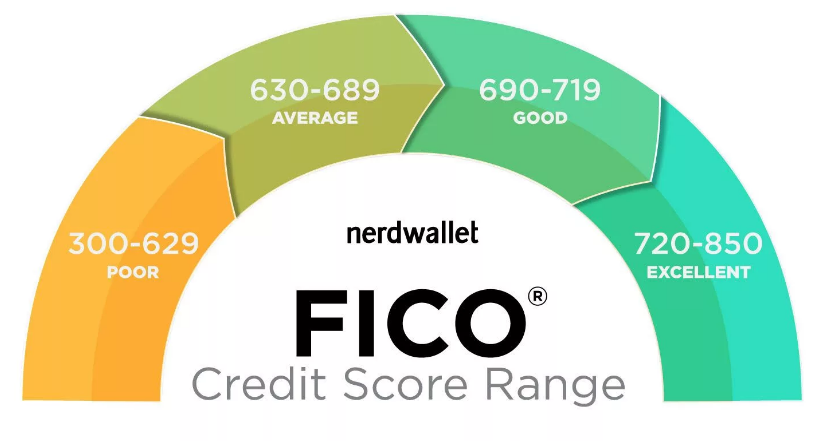

Из гистограмм и картинки видно, что на нижней гистограмме ошиблись с ноликом скорее всего. Исправляю.

In [210]:
#for idx, row in df_train.iterrows():
 #   if (row.Credit_Score > 1000):
  #      df_train.loc[idx, 'Credit_Score'] = row.Credit_Score/10

**Tax_Liens**

In [211]:
#df_train.Tax_Liens.value_counts()

In [212]:
#sns.lmplot(x='Tax_Liens', y='Number_of_Credit_Problems', data=df_train[(df_train.Tax_Liens < 30)])

Здесь и обрабатывать то нечего. То что большинство не имеет налогового обременения на счета это нормально.

**Number_of_Credit_Problems**

In [213]:
#df_train.Number_of_Credit_Problems.value_counts()

In [214]:
#sns.lmplot(y='Bankruptcies', x='Number_of_Credit_Problems', data=df_train[(df_train.Number_of_Credit_Problems < 30)])

Все ровно.

**Current_Loan_Amount**

In [215]:
#sns.displot(x='Current_Loan_Amount', kde=True,
 #           data=df_train[df_train.Current_Loan_Amount < 1000000 ])

In [216]:
#df_train.Current_Loan_Amount[df_train.Current_Loan_Amount > 2000000 ].value_counts()

In [217]:
#df_train.Current_Loan_Amount.hist(bins=40)

Правый выброс можно приравнять 870 Nan

In [218]:
#df_train.loc[df_train.Current_Loan_Amount > 2000000, 'Current_Loan_Amount'] = np.nan

**Monthly_Debt**

In [219]:
#df_train.Monthly_Debt[df_train.Monthly_Debt < 75000].hist(bins=40)

In [220]:
#df_train.Monthly_Debt[df_train.Monthly_Debt > 75000].hist(bins=40)

In [221]:
#df_train.Monthly_Debt[df_train.Monthly_Debt > 75000].value_counts()

Аномалий не видно.

**Years_of_Credit_History**

In [222]:
#df_train.Years_of_Credit_History.hist()

In [223]:
#df_train.Years_of_Credit_History[df_train.Years_of_Credit_History > 50].hist()

Все ровно.

**Current_Credit_Balance**

In [224]:
#df_train.Current_Credit_Balance.hist(bins=40)

In [225]:
#df_train.Current_Credit_Balance[df_train.Current_Credit_Balance > 1800000].hist(bins=40)

Аномалий нет.

**Maximum_Open_Credit**

In [226]:
#df_train.Maximum_Open_Credit.hist(bins=40)

In [227]:
#df_train.Maximum_Open_Credit[df_train.Maximum_Open_Credit < 4000000].hist(bins=40)

In [228]:
#df_train.Maximum_Open_Credit[df_train.Maximum_Open_Credit > 3000000].value_counts()

Нормально все.

**Bankruptcies**

In [229]:
#df_train.Bankruptcies.value_counts()

Можно ограничить кол-во банкротств пятью.

In [230]:
#df_train.loc[df_train.Bankruptcies > 5, 'Bankruptcies'] = 1

Здесь 0,2% Нанов. Признак почти не коррелирует с таргетом, поэтому не буду заморачиваться с длинным кодом, заменю на нули.

In [231]:
#df_train.Bankruptcies = df_train.Bankruptcies.fillna(20)

In [232]:
#for idx, row in df_train.iterrows():
 #   if row.Bankruptcies == 20:
  #      df_train.loc[idx, 'Bankruptcies'] = 0

**Months_since_last_delinquent**

In [233]:
#df_train.Months_since_last_delinquent.hist(bins=40)

In [234]:
#df_train.Months_since_last_delinquent[df_train.Months_since_last_delinquent > 80].value_counts()

OK.

## 6. **Обработка Nan**  <a class='anchor' id='eda'>

**Months_since_last_delinquent**

In [235]:
#df_train['Months_since_last_delinquent_nan'] = 0
#df_train.loc[df_train.Months_since_last_delinquent.isna(), 'Months_since_last_delinquent_nan'] = 1

In [236]:
#df_train.Months_since_last_delinquent.hist(bins=30)

In [237]:
#df_train[df_train.Months_since_last_delinquent_nan == 0].Credit_Default.value_counts()

In [238]:
#df_train[(df_train.Months_since_last_delinquent_nan == 0) & (df_train.Months_since_last_delinquent == 0)].Credit_Default.value_counts()

In [239]:
#df_train[df_train.Months_since_last_delinquent_nan == 1].Number_of_Credit_Problems.value_counts()

In [240]:
#df_train[(df_train.Months_since_last_delinquent_nan == 0) & (df_train.Months_since_last_delinquent == 0)].Number_of_Credit_Problems.value_counts()

In [241]:
#df_train[df_train.Months_since_last_delinquent_nan == 1].Bankruptcies.value_counts()

In [242]:
#df_train[(df_train.Months_since_last_delinquent_nan == 0) & (df_train.Months_since_last_delinquent == 0)].Bankruptcies.value_counts()

In [243]:
#df_train[df_train.Months_since_last_delinquent_nan == 1].Credit_Score.hist()

In [244]:
#df_train[df_train.Months_since_last_delinquent_nan == 1].Annual_Income.hist(bins=40)

In [245]:
#Z=df_train[['Tax_Liens', 'Number_of_Open_Accounts', 'Years_of_Credit_History', 
 #         'Maximum_Open_Credit', 'Number_of_Credit_Problems', 'Bankruptcies', 
  #        'Current_Credit_Balance', 'Monthly_Debt', 'Credit_Default',
   #       'Term_Mortgage',	'Term_Own_Rent',	'Purpose_business_small',	'Purpose_game_other',	
    #      'Purpose_renewable energy',	'Home_Ownership_Long Term',	'Home_Ownership_Short Term']][df_train.Months_since_last_delinquent_nan==0]

In [246]:
#w=df_train['Months_since_last_delinquent'][df_train.Months_since_last_delinquent_nan==0]
#Z_train, Z_test, w_train, w_test = train_test_split(Z, w, shuffle=True, test_size=0.25)

*GradientBoostingRegressor*

In [247]:
#gb_model = GradientBoostingRegressor(criterion='mse',
 #                         min_samples_leaf=10,
  #                        random_state=42,
   #                       #n_estimators=100,
                          #max_depth=7
    #                     )
#gb_model.fit(Z_train, w_train)

In [248]:
#%%time
#params = {'n_estimators':[50, 100, 200, 400], 
 #         'max_depth':[3, 5, 7, 10],
  #        'min_samples_leaf': [3, 5, 7, 10],
   #       'max_features': np.arange(5, 10)}

#gs = GridSearchCV(gb_model, params, 
 #                 scoring='r2', # метрика 
  #                cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
   #                        random_state=21, 
    #                       shuffle=True),
     #             n_jobs=-1
      #            )
#gs.fit(Z_train, w_train)

In [249]:
#gs.best_score_

In [250]:
#gs.best_params_

In [251]:
#final_model = GradientBoostingRegressor(criterion='mse',
 #                                       max_depth=3,
  #                                      max_features=5,
   #                                     min_samples_leaf=7,
    #                                    random_state=42,  
     #                                   n_estimators=50)
#final_model.fit(Z_train, w_train)

In [252]:
#w_train_preds = final_model.predict(Z_train)
#w_test_preds = final_model.predict(Z_test)
#evaluate_preds_nan(w_train.values, w_train_preds, w_test.values, w_test_preds)

*XGBRegressor*

In [253]:
#gs = GridSearchCV(
 #           estimator=xgb.XGBRegressor(),
  #          param_grid={"learning_rate": (0.05, 0.10, 0.15),
   #                     "max_depth": [ 3, 4, 5, 6, 8],
    #                    "min_child_weight": [ 1, 3, 5, 7],
     #                   "gamma":[ 0.0, 0.1, 0.2],
      #                  "colsample_bytree":[ 0.3, 0.4],},
       #     cv=3, scoring='r2', verbose=0, n_jobs=-1)

#gs.fit(Z_train, w_train)

In [254]:
#gs.best_params_

In [255]:
#gs.best_score_

Модели дали близкую к 0 метрику. Признак линейно ни с кем не коррелирует. Но ввиду того что очень мало нулевых значений, можно предположить, что наны просто не заполнили нулями. Поэтому сохраню этот признак в отдельный датафрейм с нулями вместо нанов а потом проверю как он влияет на точность модели.

In [256]:
#df_train.Months_since_last_delinquent=df_train.Months_since_last_delinquent.fillna(0)

**Annual_Income**

Модели не дали хорошую метрику качества. Моделями восстановить не получится.

In [257]:
#df_train.Annual_Income=df_train.Annual_Income.fillna(0)

In [258]:
#sns.lmplot(x='Annual_Income', y='Monthly_Debt', data=df_train[(df_train.Annual_Income < 14000000)])

In [259]:
#list1 = list(range(1,100000,100))
#for i in range(len(list1)-1):
 # mdn=df_train.Annual_Income[(df_train.Monthly_Debt >= list1[i-1]) & (df_train.Monthly_Debt < list1[i]) & (df_train.Annual_Income > \
  #                                                                            5) & (df_train.Annual_Income <= 7000000)].median()
  #df_train.loc[(df_train.Monthly_Debt >= list1[i-1]) & (df_train.Monthly_Debt < list1[i]) & (df_train.Annual_Income  == 0), \
   #            'Annual_Income'] = mdn

In [260]:
#df_train.Annual_Income=df_train.Annual_Income.fillna(df_train.Annual_Income.median()) 

*Credit_Score*

In [261]:
#df_train['Credit_Score_nan'] = 0
#df_train.loc[df_train.Credit_Score.isna(), 'Credit_Score_nan'] = 1

In [262]:
#Z=df_train[['Annual_Income', 'Tax_Liens', 'Number_of_Open_Accounts',
 #      'Years_of_Credit_History', 'Maximum_Open_Credit',
  #     'Number_of_Credit_Problems', 'Bankruptcies', 'Current_Credit_Balance',
   #####    'Monthly_Debt', 'Credit_Default', 'Term_Mortgage',
       #'Term_Own_Rent', 'Purpose_business_small', 'Purpose_game_other',
       #'Purpose_renewable energy', 'Home_Ownership_Long Term',
       #'Home_Ownership_Short Term', 'Annual_Income_nan']][df_train.Credit_Score_nan==0]

In [263]:
#w=df_train['Credit_Score'][df_train.Credit_Score_nan==0]
#Z_train, Z_test, w_train, w_test = train_test_split(Z, w, shuffle=True, test_size=0.25)

In [264]:
#b_model = GradientBoostingRegressor(criterion='mse',
 #                         min_samples_leaf=10,
  #                        random_state=42,
   #                       #n_estimators=100,
    #                      #max_depth=7
     #                    )
#gb_model.fit(Z_train, w_train)

In [265]:
#%%time
#params = {'n_estimators':[50, 100, 200, 400], 
 #         'max_depth':[3, 5, 7, 10],
  #        'min_samples_leaf': [3, 5, 7, 10],
   #       'max_features': [5, 7, 10]}

#gs = GridSearchCV(gb_model, params, 
 #                 scoring='r2', # метрика 
  #                cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
   #                        random_state=21, 
    #                       shuffle=True),
     #             n_jobs=-1
      #            )
#gs.fit(Z_train, w_train)

In [266]:
#gs.best_score_

In [267]:
#gs.best_params_

In [268]:
#final_model = GradientBoostingRegressor(criterion='mse',
 #                                       max_depth=3,
  #                                      max_features=10,
   #                                     min_samples_leaf=7,
    #                                    random_state=42,  
     #                                   n_estimators=50)
#final_model.fit(Z_train, w_train)

In [269]:
#w_train_preds = final_model.predict(Z_train)
#w_test_preds = final_model.predict(Z_test)
#evaluate_preds_nan(w_train.values, w_train_preds, w_test.values, w_test_preds)

In [270]:
#df_train.Credit_Score.isna().sum()

XGBRegressor

In [271]:
#%%time
#gs = GridSearchCV(
 #           estimator=xgb.XGBRegressor(),
  #          param_grid={"learning_rate": (0.05, 0.10, 0.15),
   #                     "max_depth": [ 3, 4, 5, 6, 8],
    #                    "min_child_weight": [ 1, 3, 5, 7],
     #                   "gamma":[ 0.0, 0.1, 0.2],
      #                  "colsample_bytree":[ 0.3, 0.4],},
       #     cv=3, scoring='r2', verbose=0, n_jobs=-1)

#gs.fit(Z_train, w_train)

In [272]:
#gs.best_score_

In [273]:
#gs.best_params_

In [274]:
#final_model = GradientBoostingRegressor(criterion='mse',
 #                                       max_depth=3,
  #                                      max_features=10,
   #                                     min_samples_leaf=7,
    #                                    random_state=42,  
     #                                   n_estimators=50)
#final_model.fit(Z_train, w_train)

In [275]:
#w_train_preds = final_model.predict(Z_train)
#w_test_preds = final_model.predict(Z_test)
#evaluate_preds_nan(w_train.values, w_train_preds, w_test.values, w_test_preds)

*Current_Loan_Amount*

In [276]:
#df_train['Current_Loan_Amount_nan'] = 0
#df_train.loc[df_train.Current_Loan_Amount.isna(), 'Current_Loan_Amount_nan'] = 1

In [277]:
#Z=df_train[['Annual_Income', 'Tax_Liens', 'Number_of_Open_Accounts',
  #     'Years_of_Credit_History', 'Maximum_Open_Credit',
  #     'Number_of_Credit_Problems', 'Bankruptcies', 'Current_Credit_Balance',
 #      'Monthly_Debt', 'Credit_Default', 'Term_Mortgage',
 #      'Term_Own_Rent', 'Purpose_business_small', 'Purpose_game_other',
  #     'Purpose_renewable energy', 'Home_Ownership_Long Term',
  #     'Home_Ownership_Short Term', 'Annual_Income_nan']][df_train.Current_Loan_Amount_nan==0]

In [278]:
#w=df_train['Current_Loan_Amount'][df_train.Current_Loan_Amount_nan==0]
#Z_train, Z_test, w_train, w_test = train_test_split(Z, w, shuffle=True, test_size=0.25)

In [279]:
#b_model = GradientBoostingRegressor(criterion='mse',
  ##                        random_state=42,
  #                        #n_estimators=100,
   #                       #max_depth=7
   #                      )
#gb_model.fit(Z_train, w_train)

In [280]:
#%%time
#params = {'n_estimators':[50, 100, 200, 400], 
 #         'max_depth':[3, 5, 7, 10],
  #        'min_samples_leaf': [3, 5, 7, 10],
   #       'max_features': [5, 7, 10]}

#gs = GridSearchCV(gb_model, params, 
 #                 scoring='r2', # метрика 
  #                cv=KFold(n_splits=5,   # k (кол-во разбиений/итераций) в кросс-валидации
   #                        random_state=21, 
    #                       shuffle=True),
     #             n_jobs=-1
      #            )
#gs.fit(Z_train, w_train)

In [281]:
#gs.best_score_

In [282]:
#gs.best_params_

In [283]:
#final_model = GradientBoostingRegressor(criterion='mse',
 #                                       max_depth=3,
  #                                      max_features=10,
   #                                     min_samples_leaf=7,
    #                                    random_state=42,  
     #                                   n_estimators=50)
#final_model.fit(Z_train, w_train)

In [284]:
#w_train_preds = final_model.predict(Z_train)
#w_test_preds = final_model.predict(Z_test)
#evaluate_preds_nan(w_train.values, w_train_preds, w_test.values, w_test_preds)

*XGBRegressor*

In [285]:
#%%time
#gs = GridSearchCV(
 #           estimator=xgb.XGBRegressor(),
  #          param_grid={"learning_rate": (0.05, 0.10, 0.15),
   #                     "max_depth": [ 3, 4, 5, 6, 8],
    #                    "min_child_weight": [ 1, 3, 5, 7],
     #                   "gamma":[ 0.0, 0.1, 0.2],
      #                  "colsample_bytree":[ 0.3, 0.4],},
       #     cv=3, scoring='r2', verbose=0, n_jobs=-1)

#gs.fit(Z_train, w_train)

In [286]:
#gs.best_score_

In [287]:
#gs.best_params_

In [288]:
#final_model = xgb.XGBRegressor(criterion='mse',
 #                                       colsample_bytree=0.4,
  #                                      gamma=0.0,
   #                                     learning_rate=0.05,
    #                                    max_depth=4,
     #                                   random_state=42,
      #                                  min_child_weight=1 
                                     #   n_estimators=50
       #                        )
#final_model.fit(Z_train, w_train)

In [289]:
#w_train_preds = final_model.predict(Z_train)
#w_test_preds = final_model.predict(Z_test)
#evaluate_preds_nan(w_train.values, w_train_preds, w_test.values, w_test_preds)

Модели не помогли.

In [290]:
#df_train.loc[df_train.Current_Loan_Amount_nan == 1, 'Current_Loan_Amount'] = 0

In [291]:
#df_train.Current_Loan_Amount.isna().sum()

Здесь корреляции почти не видно. Признак хорошо коррелирует с таргетом. Попробую через таргет энкодинг сгенерировать признак для обработки нанов.

In [292]:
#sns.lmplot(x='Current_Loan_Amount', y='target_encode_Credit_Score', data=df_train[(df_train.target_encode_Credit_Score < 100000) & (df_train.Current_Loan_Amount< 10000000)])

In [293]:
#sns.lmplot(x='Current_Loan_Amount', y='target_encode_Credit_Score', data=df_train[(df_train.target_encode_Credit_Score < 100000) & (df_train.Current_Loan_Amount == 0)])

In [294]:
#sns.lmplot(x='Current_Loan_Amount', y='Credit_Score', data=df_train[(df_train.Credit_Score < 100000) & (df_train.Current_Loan_Amount< 10000000)])

In [295]:
#df_test[(df_test.Credit_Score == np.nan) & (df_test.Current_Loan_Amount == 0)]

In [296]:
#df_train.Credit_Score.value_counts()

## 8. **Масштабрование данных**  <a class='anchor' id='eda'>

In [297]:
#scaler = StandardScaler()

#df_norm = df_train.copy()
#df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

#df = df_norm.copy()

In [298]:
#df_norm.head()

**Сохранение модели для масштабирования данных**

In [299]:
#with open('scaler.pkl', 'wb') as file:
#    pickle.dump(scaler, file)

## 7. **КОРРЕЛЯЦИЯ**  <a class='anchor' id='eda'>

Построю корреляцию по таргету на стандартизованных признаках.

In [300]:
#corr_with_target = df_train_med[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

#plt.figure(figsize=(10, 8))

#sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

#plt.title('Correlation with target variable')
#plt.show()

In [301]:
#plt.figure(figsize = (15,10))

#3sns.set(font_scale=1.4)

#corr_matrix = df_norm.corr()
#corr_matrix = np.round(corr_matrix, 2)  # округлим до 2 знаков
#corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # если корреляция меньше 0,3, то мы заменим на 0

#sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

#plt.title('Correlation matrix')
#plt.show()

### Разбиение на train и test<a class="anchor" id="train_and_test"></a>

In [302]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)

In [303]:
df_train=df_train.rename(columns={'Home Ownership': 'Home_Ownership', 'Annual Income': 'Annual_Income', 'Years in current job': 'Years_in_current_job',
                         'Tax Liens': 'Tax_Liens', 'Number of Open Accounts': 'Number_of_Open_Accounts', 'Years of Credit History': 'Years_of_Credit_History', 
                         'Maximum Open Credit': 'Maximum_Open_Credit', 'Number of Credit Problems': 'Number_of_Credit_Problems', 'Months since last delinquent': 'Months_since_last_delinquent', 
                         'Current Loan Amount': 'Current_Loan_Amount', 'Current Credit Balance': 'Current_Credit_Balance', 'Monthly Debt': 'Monthly_Debt', 
                         'Credit Score': 'Credit_Score', 'Credit Default': 'Credit_Default'})

In [304]:
df_test = pd.read_csv(TEST_DATASET_PATH)

In [305]:
df_test=df_test.rename(columns={'Home Ownership': 'Home_Ownership', 'Annual Income': 'Annual_Income', 'Years in current job': 'Years_in_current_job',
                         'Tax Liens': 'Tax_Liens', 'Number of Open Accounts': 'Number_of_Open_Accounts', 'Years of Credit History': 'Years_of_Credit_History', 
                         'Maximum Open Credit': 'Maximum_Open_Credit', 'Number of Credit Problems': 'Number_of_Credit_Problems', 'Months since last delinquent': 'Months_since_last_delinquent', 
                         'Current Loan Amount': 'Current_Loan_Amount', 'Current Credit Balance': 'Current_Credit_Balance', 'Monthly Debt': 'Monthly_Debt', 
                         'Credit Score': 'Credit_Score'})

In [306]:
df_train=change_Purpose(df_train)
df_test=change_Purpose(df_test)

In [307]:
X = df_train.drop(columns=[TARGET_NAME])
y = df_train[TARGET_NAME]
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    shuffle=True,
                                                    test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0    0.718286
1    0.281714
Name: Credit_Default, dtype: float64

0    0.718222
1    0.281778
Name: Credit_Default, dtype: float64

## 1. **DATAPREPROCESSING**  <a class='anchor' id='eda'>

In [308]:
def imputer_rfr(data, target_col):
    #для воспроизведения недостающих значений на тестовых данных с обучением

    data[target_col + '_nan'] = 0
    data.loc[data[target_col].isna(), target_col + '_nan'] = 1
    
    features = data.columns
    
    data = data[features]
    
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = RandomForestRegressor(n_estimators=100,
                                  max_depth=7,
                                  random_state=42,
                                  verbose=1)
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2(y_train, pred_train)}")
    print(f"r2 на test: {r2(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return model, data

In [309]:
def imputer_rfr_test(data, target_col, model):
    #data = data.copy()

    
    features = data.columns
    
    data = data[features]
    #train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    return data

In [310]:
#Уменьшил до 0,1 переобучение
#for idx, row in X_train.iterrows():
#    if (row.Credit_Score > 1000):
 #       X_train.loc[idx, 'Credit_Score'] = row.Credit_Score/10
#for idx, row in X_test.iterrows():
 #   if (row.Credit_Score > 1000):
  #      X_test.loc[idx, 'Credit_Score'] = row.Credit_Score/10

In [311]:
#создал самую важную для обучения функцию
#X_train['Current_Loan_Amount_over'] = 0
#X_test['Current_Loan_Amount_over'] = 0
#X_train.loc[X_train.Current_Loan_Amount == 99999999.0, 'Current_Loan_Amount_over'] = 1
#X_test.loc[X_test.Current_Loan_Amount == 99999999.0, 'Current_Loan_Amount_over'] = 1

In [312]:
#X_train.loc[X_train.Bankruptcies > 5, 'Bankruptcies'] = 1

In [313]:
#признаки для определения недостающих значений
#def finder_nan(data, target_col):
 #   #data = data.copy()
#    data[target_col + '_nan'] = 0
 #   data.loc[data[target_col].isna(), target_col + '_nan'] = 1

#finder_nan(X_train, 'Annual_Income')
#finder_nan(X_test, 'Annual_Income')
#finder_nan(X_train, 'Years_in_current_job')
#finder_nan(X_test, 'Years_in_current_job')
#finder_nan(X_train, 'Months_since_last_delinquent')
#finder_nan(X_test, 'Months_since_last_delinquent')
#finder_nan(X_train, 'Bankruptcies')
#finder_nan(X_test, 'Bankruptcies')
#finder_nan(X_train, 'Credit_Score')
#finder_nan(X_test, 'Credit_Score')

In [314]:
#Предварительно обработаю Наны
#X_train.Months_since_last_delinquent=X_train.Months_since_last_delinquent.fillna(0)
#X_test.Months_since_last_delinquent=X_test.Months_since_last_delinquent.fillna(0)
#X_train.Annual_Income.fillna(X_train.Annual_Income.median(), inplace=True)
#X_test.Annual_Income.fillna(X_train.Annual_Income.median(), inplace=True)
#X_train.Credit_Score.fillna(X_train.Credit_Score.median(), inplace=True)
#X_test.Credit_Score.fillna(X_train.Credit_Score.median(), inplace=True)
#X_train.Years_in_current_job.fillna('10+ years', inplace=True)
#X_test.Years_in_current_job.fillna('10+ years', inplace=True)

In [315]:
#обработка категориальных признаков
#X_train['Years_in_current_job'] = X_train['Years_in_current_job'].replace({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, '6 years':6, '7 years':7,'8 years':8,'9 years':9,'10+ years':10})
#X_test['Years_in_current_job'] = X_test['Years_in_current_job'].replace({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, '6 years':6, '7 years':7,'8 years':8,'9 years':9,'10+ years':10})
#X_train.Years_in_current_job=X_train.Years_in_current_job.astype(dtype='int32')
#X_test.Years_in_current_job=X_test.Years_in_current_job.astype(dtype='int32')
#X_train.loc[X_train.Home_Ownership == 'Rent', 'Home_Ownership'] = 0
#X_test.loc[X_test.Home_Ownership == 'Rent', 'Home_Ownership'] = 0
#X_train.loc[X_train.Home_Ownership == 'Have Mortgage', 'Home_Ownership'] = 1
#X_test.loc[X_test.Home_Ownership == 'Have Mortgage', 'Home_Ownership'] = 1
#X_train.loc[X_train.Home_Ownership == 'Home Mortgage', 'Home_Ownership'] = 2
#X_test.loc[X_test.Home_Ownership == 'Home Mortgage', 'Home_Ownership'] = 2
#X_train.loc[X_train.Home_Ownership == 'Own Home', 'Home_Ownership'] = 3
#X_test.loc[X_test.Home_Ownership == 'Own Home', 'Home_Ownership'] = 3
#X_train.loc[X_train.Purpose == 'educational_debt', 'Purpose'] = 0
#X_test.loc[X_test.Purpose == 'educational_debt', 'Purpose'] = 0
#X_train.loc[X_train.Purpose == 'other_major', 'Purpose'] = 1
#X_test.loc[X_test.Purpose == 'other_major', 'Purpose'] = 1
#X_train.loc[X_train.Purpose == 'business_small', 'Purpose'] = 2
#X_test.loc[X_test.Purpose == 'business_small', 'Purpose'] = 2
#X_train.loc[X_train.Purpose == 'renewable energy', 'Purpose'] = 3
#X_test.loc[X_test.Purpose == 'renewable energy', 'Purpose'] = 3
#X_train.loc[X_train.Term == 'Short Term', 'Term'] = 0
#X_test.loc[X_test.Term == 'Short Term', 'Term'] = 0
#X_train.loc[X_train.Term == 'Long Term', 'Term'] = 1
#X_test.loc[X_test.Term == 'Long Term', 'Term'] = 1


Перевел вышеуказанный код в класс DataPreprocessing

In [316]:
class DataPreprocessing:
    
    
    def __init__(self):
        self.medians=None
        
    def fit(self, X):     
        # Расчет медиан
        self.medians = X.median()
  
    def transform(self, X):
        """Убираем выбросы"""
        X.loc[X.Annual_Income < 140000, 'Annual_Income'] = np.nan
        """Исправление аномалии в признаках"""
        for idx, row in X.iterrows():
            if (row.Credit_Score > 1000):
                X.loc[idx, 'Credit_Score'] = row.Credit_Score/10
                
        X['Current_Loan_Amount_over'] = 0
        X.loc[X.Current_Loan_Amount == 99999999.0, 'Current_Loan_Amount_over'] = 1
        
        X.loc[X.Bankruptcies > 5, 'Bankruptcies'] = 1
        
        """Создание признаков для Nan"""
        self.finder_nan(X, 'Annual_Income')
        self.finder_nan(X, 'Years_in_current_job')
        self.finder_nan(X, 'Months_since_last_delinquent')
        self.finder_nan(X, 'Bankruptcies')
        self.finder_nan(X, 'Credit_Score')
        
        """Предварительная обработка Нанов, заполние их медианными значениями
"""
        X.Months_since_last_delinquent=X.Months_since_last_delinquent.fillna(0)
        X.Years_in_current_job.fillna('10+ years', inplace=True)
        X.fillna(self.medians, inplace=True)
        
        """Обработка категориальных признаков"""
        X['Years_in_current_job'] = X['Years_in_current_job'].replace({'< 1 year':0, '1 year':1, '2 years':2, '3 years':3, '4 years':4, '5 years':5, '6 years':6, '7 years':7,'8 years':8,'9 years':9,'10+ years':10})
        X.Years_in_current_job=X.Years_in_current_job.astype(dtype='int32')
        
        X.loc[X.Home_Ownership == 'Rent', 'Home_Ownership'] = 0
        X.loc[X.Home_Ownership == 'Have Mortgage', 'Home_Ownership'] = 1
        X.loc[X.Home_Ownership == 'Home Mortgage', 'Home_Ownership'] = 2
        X.loc[X.Home_Ownership == 'Own Home', 'Home_Ownership'] = 3

        X.loc[X.Purpose == 'educational_debt', 'Purpose'] = 0
        X.loc[X.Purpose == 'other_major', 'Purpose'] = 1
        X.loc[X.Purpose == 'business_small', 'Purpose'] = 2
        X.loc[X.Purpose == 'renewable energy', 'Purpose'] = 3
        
        X.loc[X.Term == 'Short Term', 'Term'] = 0
        X.loc[X.Term == 'Long Term', 'Term'] = 1
        
        return X
        
    
    def finder_nan(self, X, target_col):
        X[target_col + '_nan'] = 0
        X.loc[X[target_col].isna(), target_col + '_nan'] = 1
        return X

In [317]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

Окончательная обработка недостающих значений. Функции сложные, с поиском лучших параметров, поэтому не стал выносить их в общий класс.

Bankruptcies

Следующий код не изменил метрики на Катбусте, но точность у модели высокая. 

In [318]:
X_train.loc[X_train.Bankruptcies_nan == 1, 'Bankruptcies'] = np.nan
feature_name = 'Bankruptcies'
Bankruptcies_predictor, X_train = imputer_rfr(X_train, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


r2 на train: 0.9001257419332971
r2 на test: 0.742296379954577


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [319]:
X_test.loc[X_test.Bankruptcies_nan == 1, 'Bankruptcies'] = np.nan
X_test = imputer_rfr_test(X_test, feature_name, Bankruptcies_predictor)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


In [320]:
X_train.Bankruptcies=X_train.Bankruptcies.astype(np.int)
X_test.Bankruptcies=X_test.Bankruptcies.astype(np.int)

Annual_Income

In [321]:
def imputer_rfr_Annual_Income(data, target_col):
    #data = data.copy()

    
    features = data.columns
    
    data = data[features]
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
        
    model = RandomForestRegressor(n_estimators=30,
                             max_depth=3,
                             min_samples_leaf=7,
                             min_samples_split=3,
                             random_state=42,
                             verbose=1)
    
    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2(y_train, pred_train)}")
    print(f"r2 на test: {r2(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    
    #parametrs = { 'n_estimators': range (10, 51, 10),
     #             'max_depth': [2, 3, 4, 5],
      #            'min_samples_leaf': [5, 6, 7, 8, 9],
       #           'min_samples_split': [3, 5, 7, 9] }
    
    #gs = GridSearchCV(model, parametrs, cv=5)
    #gs.fit(X_train, y_train)
    
    #gs_best_params=gs.best_params_
    
    return model, data

In [322]:
X_train.loc[X_train.Annual_Income_nan == 1, 'Annual_Income'] = np.nan
feature_name = 'Annual_Income'
Annual_Income_predictor, X_train = imputer_rfr_Annual_Income(X_train, feature_name)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.2s finished


r2 на train: 0.4144249301876113
r2 на test: 0.4068101100384822


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


In [323]:
#gs_best_params

In [324]:
X_test.loc[X_test.Annual_Income_nan == 1, 'Annual_Income'] = np.nan
X_test = imputer_rfr_test(X_test, feature_name, Annual_Income_predictor)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.0s finished


Current_Loan_Amount

In [325]:
def imputer_rfr_Current_Loan_Amount(data, target_col):
    #data = data.copy()

    
    features = data.columns
    
    data = data[features]
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)
    
    model = CatBoostRegressor(
            eval_metric='R2',
            silent=True,
            one_hot_max_size=20,
            early_stopping_rounds=40,
            boosting_type='Ordered',
            allow_writing_files=False,
            depth=4,
            iterations=500,
            learning_rate=0.03,
            l2_leaf_reg=8
            )

    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2(y_train, pred_train)}")
    print(f"r2 на test: {r2(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    
    parametrs = {'iterations': [300, 400, 500],
              'depth': [3, 4, 5],
              'learning_rate': [0.03, 0.3, 0.5],
              'l2_leaf_reg': [3, 4, 5, 6, 7, 8] }
    
    #gs = GridSearchCV(model, parametrs, cv=5)
    #gs.fit(X_train, y_train)
    
    #gs_best_params=gs.best_params_
    
    return model, data

In [326]:
X_train.loc[X_train.Current_Loan_Amount_over == 1, 'Current_Loan_Amount'] = np.nan
feature_name = 'Current_Loan_Amount'
Current_Loan_Amount_predictor, X_train = imputer_rfr_Current_Loan_Amount(X_train, feature_name)

r2 на train: 0.5911353492398608
r2 на test: 0.5200504081306092


In [327]:
#gs_best_params

In [328]:
X_test.loc[X_test.Current_Loan_Amount_over == 1, 'Current_Loan_Amount'] = np.nan
X_test = imputer_rfr_test(X_test, feature_name, Current_Loan_Amount_predictor)

Credit_Score

In [329]:
def imputer_rfr_Credit_Score(data, target_col):
    #data = data.copy()

    
    features = data.columns
    
    data = data[features]
    train = data[~data[target_col].isna()]
    predict_data = data[data[target_col].isna()]

    X = train.drop(columns=target_col)
    y = train[target_col]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                        test_size=0.2,
                                                        shuffle=True,
                                                        random_state=32)

        
    model = CatBoostRegressor(
            eval_metric='R2',
            silent=True,
            one_hot_max_size=20,
            early_stopping_rounds=40,
            boosting_type='Ordered',
            allow_writing_files=False,
            depth=4,
            iterations=500,
            learning_rate=0.03,
            l2_leaf_reg=8
            )

    model.fit(X_train, y_train)
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    print(f"r2 на train: {r2(y_train, pred_train)}")
    print(f"r2 на test: {r2(y_test, pred_test)}")

    pred = model.predict(predict_data.drop(columns=target_col))

    data.loc[data[target_col].isna(), target_col] = list(pred)
    
    parametrs = {'iterations': [300, 400, 500],
              'depth': [3, 4, 5],
              'learning_rate': [0.03, 0.3, 0.5],
              'l2_leaf_reg': [3, 4, 5, 6, 7, 8] }
    
    #gs = GridSearchCV(model, parametrs, cv=5)
    #gs.fit(X_train, y_train)
    
    #gs_best_params=gs.best_params_
    
    return model, data

In [330]:
X_train.loc[X_train.Credit_Score_nan == 1, 'Credit_Score'] = np.nan
feature_name = 'Credit_Score'
Credit_Score_predictor, X_train = imputer_rfr_Credit_Score(X_train, feature_name)

r2 на train: 0.4351818131764762
r2 на test: 0.34858731744145643


In [331]:
X_test.loc[X_test.Credit_Score_nan == 1, 'Credit_Score'] = np.nan
X_test = imputer_rfr_test(X_test, feature_name, Credit_Score_predictor)

# Балансировка данных

In [ ]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME, method='smote')
    
df_balanced[TARGET_NAME].value_counts()

In [ ]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

In [ ]:
X_train_balanced.Home_Ownership=X_train_balanced.Home_Ownership.astype('int32')
X_test.Home_Ownership=X_test.Home_Ownership.astype('int32')
X_train.Home_Ownership=X_train.Home_Ownership.astype('int32')
X_train_balanced.Purpose=X_train_balanced.Purpose.astype('int32')
X_test.Purpose=X_test.Purpose.astype('int32')
X_train.Purpose=X_train.Purpose.astype('int32')
X_train_balanced.Term=X_train_balanced.Term.astype('int32')
X_test.Term=X_test.Term.astype('int32')
X_train.Term=X_train.Term.astype('int32')

XGBoost

In [ ]:
#model_xgb = xgb.XGBClassifier(random_state=21, 
 #                             max_depth=2, 
  #                            )
#model_xgb.fit(X_train_balanced, y_train_balanced)

#evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

In [ ]:
#param_dist = {"max_depth": [10,30,50],
 #             "min_child_weight" : [1,3,6],
  #            "n_estimators": [50, 100, 200],
   #           "learning_rate": [0.05, 0.1,0.16],}
#grid_search = GridSearchCV(model_xgb, param_grid=param_dist, cv = 3, 
 #                                  verbose=10, n_jobs=-1)
#grid_search.fit(X_train_balanced, y_train_balanced)

#grid_search.best_estimator_

In [ ]:
#cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [ ]:
#%%time
#grid_search = GridSearchCV(param_grid=param_dist, estimator=model_xgb, cv=cv, verbose=0, scoring='f1')
#grid_search.fit(X_train_balanced, y_train_balanced)
#display(grid_search.best_params_, grid_search.best_score_)

In [ ]:
#best_model_xgb = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
 #             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
  #            importance_type='gain',
   #           learning_rate=0.1, max_delta_step=0, max_depth=10,
    #          min_child_weight=1,
     #         n_estimators=200, n_jobs=2, num_parallel_tree=1, random_state=21,
      #        reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
       #       tree_method='exact', validate_parameters=1)
#best_model_xgb.fit(X_train_balanced, y_train_balanced)

#evaluate_preds(best_model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

LightGBM

In [ ]:
#%%time
#model_lgbm = lgbm.LGBMClassifier(random_state=21, 
 #                                 class_weight={0:1, 1:2.55},
  #                                n_estimators=50
   #                             )
#model_lgbm.fit(X_train, y_train)

#evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

In [ ]:
#param_dist = {"max_depth": [25,50, 75],
 #             "learning_rate" : [0.01,0.05,0.1],
  #            "num_leaves": [300,900,1200],
   #           "n_estimators": [50, 100]
    #         }
#grid_search = GridSearchCV(model_lgbm, n_jobs=-1, param_grid=param_dist, cv = 3, scoring="f1", verbose=5)
#grid_search.fit(X_train, y_train)
#grid_search.best_estimator_

In [ ]:
#best_model_lgbm = lgbm.LGBMClassifier(random_state=21, 
 #                                 class_weight={0:1, 1:2.55},
  #                                n_estimators=50,
   #                               num_leaves=300,
    #                              learning_rate=0.01,
     #                             max_depth=2
      #                          )

#best_model_lgbm.fit(X_train, y_train)

In [ ]:
#evaluate_preds(best_model_lgbm, X_train, X_test, y_train, y_test)

Catboost

Лучший результат показал Катбуст

In [334]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

2.5496957403651117

In [337]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     'cat_features': ['Home_Ownership', 'Years_in_current_job',
                      'Purpose', 'Term', 'Current_Loan_Amount_over', 'Annual_Income_nan',
                      'Credit_Score_nan'],
     'eval_metric':'F1',
     'early_stopping_rounds':40
}

In [338]:
%%time

model_catb = catb.CatBoostClassifier(**frozen_params, iterations=300, max_depth=5)
model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

TRAIN

              precision    recall  f1-score   support

           0       0.85      0.56      0.68      3771
           1       0.40      0.75      0.52      1479

    accuracy                           0.62      5250
   macro avg       0.63      0.66      0.60      5250
weighted avg       0.73      0.62      0.63      5250

TEST

              precision    recall  f1-score   support

           0       0.83      0.55      0.66      1616
           1       0.38      0.71      0.50       634

    accuracy                           0.60      2250
   macro avg       0.61      0.63      0.58      2250
weighted avg       0.70      0.60      0.62      2250

CONFUSION MATRIX

col_0             0    1
Credit_Default          
0               896  720
1               187  447
CPU times: user 1.03 s, sys: 93.8 ms, total: 1.12 s
Wall time: 1.4 s


In [339]:
feature_importances = pd.DataFrame(zip(X_train.columns, model_catb.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
15,Current_Loan_Amount_over,84.378245
10,Term,4.997826
14,Credit_Score,4.028659
1,Annual_Income,2.007681
5,Maximum_Open_Credit,1.220321
11,Current_Loan_Amount,0.738864
17,Years_in_current_job_nan,0.572891
12,Current_Credit_Balance,0.395821
7,Months_since_last_delinquent,0.393821
3,Number_of_Open_Accounts,0.341567


Попытка снижения степени переобучения

In [340]:
%%time
model_catb = catb.CatBoostClassifier(class_weights=[1,2.54], silent=True, random_state=21)
params = {'iterations':[50, 100, 200],
          'depth':[3, 5, 8],
          'learning_rate' : [0.03, 0.1, 0.15],
          'l2_leaf_reg': [1,4,9]}
cv=KFold(n_splits=3, random_state=21, shuffle=True)
rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X_train, y_train)
rs.best_params_

CPU times: user 1.67 s, sys: 180 ms, total: 1.85 s
Wall time: 26.3 s


{'learning_rate': 0.03, 'l2_leaf_reg': 4, 'iterations': 200, 'depth': 5}

In [ ]:
rs.best_score_

In [ ]:
best_model_catb = catb.CatBoostClassifier(class_weights=[1,2.54], 
                                          silent=True, 
                                          random_state=21,
                                          learning_rate=0.15, 
                                          l2_leaf_reg=4, 
                                          iterations=50, 
                                          depth=3
                                         )

In [ ]:
best_model_catb.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

evaluate_preds(best_model_catb, X_train, X_test, y_train, y_test)

In [ ]:
y_train_proba=predict_proba_compare(best_model_catb, X_test, X_train, y_test, y_train, 0.4)

In [ ]:
params = {
    'reg_lambda': np.linspace(0.1, 4, 80)
}

In [ ]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=5)

этим методом модель не улучшить

In [ ]:
cv = StratifiedKFold(n_splits=3, random_state=21, shuffle=True)

In [ ]:
grid_search = model.randomized_search(params, X_train, y_train, n_iter=50, cv=cv, stratified=True, plot=True, refit=True)

In [ ]:
cv_results = pd.DataFrame(grid_search["cv_results"])

In [ ]:
grid_search.get('params')

In [ ]:
model = catb.CatBoostClassifier(**frozen_params,
                                iterations=300,
                                max_depth=5,
                                l2_leaf_reg=2)
model.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test))

In [ ]:
%%time

evaluate_preds(model, X_train, X_test, y_train, y_test)

Выбор порога вероятности для определения класса

In [ ]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (12, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [ ]:
y_test_pred_probs = model.predict_proba(X_test)
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

Говорит что оптимальный порог вероятности 0,5

Создал функцию для изменения результирующей выборки в зависимости от порога вероятности

In [ ]:
y_train_proba=predict_proba_compare(model, X_test, X_train, y_test, y_train, 0.51)

Хочу целевую метрику f1-score по нулю!)))

Кривая обучения

In [ ]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(12,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [ ]:
show_learning_curve_plot(model, X_test, y_test)

У первоначальной модели переобучение нулевое, поэтому все "улучшайзеры" не помогают.